# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
#env = UnityEnvironment(file_name='./Reacher_Linux_1/Reacher.x86_64')
env = UnityEnvironment(file_name='./Reacher_Linux_20/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

---
# My Implementation

## Prerequisites

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import namedtuple, deque
import time
import random
import copy
import os


#################################
#  Initialization:
#################################

# Select environment either with one or 20 reacher arms
#env = UnityEnvironment(file_name="./Reacher_Linux_1/Reacher.x86_64")
env = UnityEnvironment(file_name="./Reacher_Linux_20/Reacher.x86_64")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

# Number of agents (should be 1 or 20)
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# Size of each action (should be 4)
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Define named tuple 'Experience'; you can use a dictionary alternatively
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Number of agents: 20
Size of each action: 4


## Definition of Actor and Critic

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# The network is used to approximate a POLICY. As a result, we suggest the following structure:
# 
# Since the observation space consists of 33 variables corresponding to position, rotation, 
# velocity, and angular velocities of the arm, the input layer shall consist of 33 neurons
#
# The output layer consists of two neurons for four floating point numbers
# between -1 and 1 which represent the torque applied to the two joints of
# the robot arm
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, seed, state_size=33, action_size=4, units_fc1 = 256, units_fc2 = 128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, units_fc1)
        self.fc2 = nn.Linear(units_fc1, units_fc2)
        self.fc3 = nn.Linear( units_fc2, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu( self.fc1(state) )
        x = F.relu( self.fc2( x ))
        action = torch.tanh( self.fc3(x) )
        return action



class Critic(nn.Module):
    def __init__(self, seed, state_size=33, action_size=4, units_fc1 = 256, units_fc2 = 128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, units_fc1)
        self.fc2 = nn.Linear(units_fc1+action_size, units_fc2)
        self.fc3 = nn.Linear(units_fc2, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        x = F.elu( self.fc1(state) )
        x = torch.cat( (x, action), dim=1 )
        x = F.elu( self.fc2(x) )
        value = self.fc3(x)
        return value



## Definition of Agent and Replay Buffer

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Experimental values:
EPS_END = 0.05
EPS_DECAY = 3e-5

class Agent():
    def __init__(self, buffer_size, batch_size, action_size, gamma, epsilon=1.0, learn_rate=0.0005):
        if not batch_size < buffer_size:
            raise Exception()

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.action_size = action_size
        self.gamma = gamma
        self.eps = epsilon

        # Initialize replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size, batch_size)

        # Initialize noise
        #self.noise = OUNoise()
        self.noise = Noise()
        self.epsilon = epsilon
        self.learn_rate = learn_rate

        # Seed the random number generator
        random.seed()
        np.random.seed()

        seed = 0

        self.actor_local = Actor(seed).to(device)
        self.actor_target = Actor(seed).to(device)

        self.critic_local = Critic(seed).to(device)
        self.critic_target = Critic(seed).to(device)

        self.hard_update_target_nets()

        self.actor_optimizer = optim.Adam( self.actor_local.parameters(), lr=self.learn_rate )
        self.critic_optimizer = optim.Adam( self.critic_local.parameters(), lr=self.learn_rate )


    # Utilizing Deep Deterministic Policy Gradient methodology (DDPG):
    def learn(self):
        # If buffer is sufficiently full, let the agent learn from his experience:
        if not self.replay_buffer.buffer_usage():
            return
        
        # Retrieve batch of experiences from the replay buffer:
        states, actions, rewards, next_states, dones = self.replay_buffer.sample_from_buffer()

        # Train the critic network:
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Critic loss:
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1.0) # Clip the gradient for the critic network (-> Udacity)
        self.critic_optimizer.step()

        # Actor loss:
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft updates:
        self.soft_update_target_nets(tau=0.001)
        

    # Take action according to epsilon-greedy-policy:
    def action(self, state, eps=1., add_noise=True):
        # Sample action from actor network:
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise and random.random() < eps:
            actions += self.noise.sample()
            self.eps = max(self.eps-EPS_DECAY, EPS_END)

        actions = np.clip(actions, -1, 1)
        return actions, self.eps # Returns used epsilon as info

    # Generates an array of action_size (i.e. 4) with uniformly distributed floats in [-1,1)
    def random_action(self):
        action = 2 * np.random.random_sample(self.action_size) - 1.0
        return action

    # Copy weights from short-term model to long-term model
    def soft_update_target_nets(self, tau=0.001):
        for t, l in zip(self.actor_target.parameters(), self.actor_local.parameters() ):
            t.data.copy_( (1-tau)*t.data + tau*l.data )

        for t, l in zip(self.critic_target.parameters(), self.critic_local.parameters() ):
            t.data.copy_( (1-tau)*t.data + tau*l.data )

    def hard_update_target_nets(self):
        self.soft_update_target_nets( tau=1.0 )


    def load_weights(self, path):
        filepath = os.path.join(path, "actor_weights_latest.pth")
        print("Loading actor network weights from", filepath)
        self.actor_local.load_state_dict(torch.load(filepath, map_location=lambda storage, loc: storage))

        filepath = os.path.join(path, "critic_weights_latest.pth")
        print("Loading critic network weights from", filepath)
        self.critic_local.load_state_dict(torch.load(filepath, map_location=lambda storage, loc: storage))
        
        self.hard_update_target_nets()


    def save_weights(self, path):
        filepath = os.path.join(path, "actor_weights_latest.pth")
        print("Saving actor network weights to", filepath)
        torch.save(self.actor_local.state_dict(), filepath) 
        filepath = os.path.join(path, "critic_weights_latest.pth")
        print("Saving critic network weights to", filepath)
        torch.save(self.critic_local.state_dict(), filepath) 


class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=self.buffer_size)

    # Insert experience into memory
    def insert_into_buffer(self, experience):
        self.replay_buffer.append(experience)

    # Randomly sample memory
    def sample_from_buffer(self):
        # Sample experience batch from experience buffer
        batch = random.sample(self.replay_buffer, self.batch_size)

        # Reorder experience batch such that we have a batch of states, a batch of actions, a batch of rewards, etc.
        # Eventually add 'if exp is not None'
        state = torch.from_numpy( np.vstack( [exp.state for exp in batch] ) ).float().to(device)
        action = torch.from_numpy( np.vstack( [exp.action for exp in batch] ) ).float().to(device)
        reward = torch.from_numpy( np.vstack( [exp.reward for exp in batch] ) ).float().to(device)
        state_next = torch.from_numpy( np.vstack( [exp.next_state for exp in batch] ) ).float().to(device)
        done = torch.from_numpy( np.vstack( [exp.done for exp in batch] ).astype(np.uint8) ).float().to(device)

        return state, action, reward, state_next, done

    # Get length of memory
    def buffer_usage(self):
        return len(self.replay_buffer) > self.batch_size


# Normally distributed noise
class Noise():
    def __init__(self, mu=0., sigma=0.2):
        self.mu = mu
        self.sigma = sigma

    def sample(self):
        #Todo: Sample from normal distribution
        return np.random.randn() # Shall be refined later!


# Ornstein-Uhlenbeck process:
class OUNoise():
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.size = size
        self.seed = random.seed(seed)
        self.mu = mu + np.ones(size)
        self.sigma = sigma
        self.theta = theta
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state += dx
        return self.state


## Training Loop

In [4]:
# Initialize the agent:
agent = Agent(buffer_size=10000, batch_size=64, gamma=0.98, epsilon=0.1, action_size=4)



def training(n_episodes=200):
    tick = 0

    success = False

    score_list = []
    score_trailing_list = deque(maxlen=100)
    score_trailing_avg_list = []

    #agent.load_weights("./checkpoints_torch")

    for episode in range(0, n_episodes):
        ticks = 0
        scores = np.zeros( shape=(num_agents,) )

        env_info = env.reset(train_mode=True)[brain_name]   # Reset the environment
        states = env_info.vector_observations                # Get the current state

        start = time.time()
        while True:
            # Select action according to policy:
            actions, _ = agent.action(states, add_noise=True)

            # Take action and record the reward and the successive state
            env_info = env.step(actions)[brain_name]
            
            rewards = np.array(env_info.rewards)
            next_states = env_info.vector_observations
            dones = env_info.local_done

            # Add experience to the agent's replay buffer:
            for idx in range(num_agents):
                exp = Experience(states[idx], actions[idx], rewards[idx], next_states[idx], dones[idx])
                agent.replay_buffer.insert_into_buffer( exp )
            
            agent.learn()

            scores += rewards
            states = next_states
            
            if np.any(dones):
                break

            ticks += 1


        end = time.time()

        score = np.mean(scores)
        score_list.append(score)
        score_trailing_list.append(score)
        score_trailing_avg = np.mean(score_trailing_list)
        score_trailing_avg_list.append(score_trailing_avg)

        print("***********************************************")
        print("Score of episode {}: {}".format(episode, score))
        print("Trailing avg. score: {:.2f}".format(score_trailing_avg))
        print("Time consumed: {:.2f} s".format(end-start))
        print("***********************************************")
        
        if score_trailing_avg > 30.0 and success == False:
            print("=============================================================================")
            print("Challenge solved at episode {}".format(episode))
            print("=============================================================================")
            success = True

        episode += 1

        if episode % 10 == 0:
            agent.save_weights("./checkpoints_torch")
            
    return score_list, score_trailing_avg_list

In [5]:
score_list, score_trailing_avg_list = training(200)

***********************************************
Score of episode 0: 0.8319999814033509
Trailing avg. score: 0.83
Time consumed: 9.92 s
***********************************************
***********************************************
Score of episode 1: 0.5519999876618386
Trailing avg. score: 0.69
Time consumed: 9.32 s
***********************************************
***********************************************
Score of episode 2: 0.48899998906999825
Trailing avg. score: 0.62
Time consumed: 9.56 s
***********************************************
***********************************************
Score of episode 3: 0.6329999858513474
Trailing avg. score: 0.63
Time consumed: 10.73 s
***********************************************
***********************************************
Score of episode 4: 0.5424999878741801
Trailing avg. score: 0.61
Time consumed: 9.58 s
***********************************************
***********************************************
Score of episode 5: 0.6864999846555

## Result Plot

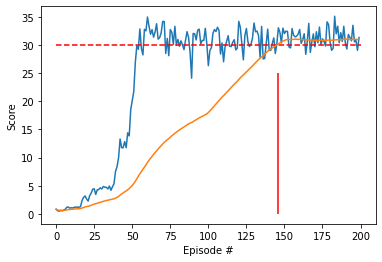

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hlines(30, 0, len(score_list), colors='red', linestyles='dashed', label='12 pts', zorder=15)
plt.vlines(146, 0, 35, colors='red', linestyles='solid', label='12 pts', zorder=15)
plt.plot(np.arange(len(score_list)), score_list, zorder=5)
plt.plot(np.arange(len(score_list)), score_trailing_avg_list, zorder=20)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Replay Loop

In [ ]:
env.close()